Customer ID: 1,Customer type: 0 Demand: 0
Customer ID: 2,Customer type: 1 Demand: 33.0
Customer ID: 3,Customer type: 1 Demand: 15.0
Customer ID: 4,Customer type: 1 Demand: 10.0
Customer ID: 5,Customer type: 1 Demand: 40.0
Customer ID: 6,Customer type: 1 Demand: 15.0
Customer ID: 7,Customer type: 1 Demand: 5.0
Customer ID: 8,Customer type: 1 Demand: 77.0
Customer ID: 9,Customer type: 1 Demand: 435.0
Customer ID: 10,Customer type: 1 Demand: 165.0
Customer ID: 11,Customer type: 1 Demand: 120.0
Customer ID: 12,Customer type: 1 Demand: 65.0
Customer ID: 13,Customer type: 1 Demand: 23.0
Customer ID: 14,Customer type: 1 Demand: 18.0
Customer ID: 15,Customer type: 1 Demand: 550.0
Customer ID: 16,Customer type: 1 Demand: 78.0
Customer ID: 17,Customer type: 1 Demand: 627.0
Customer ID: 18,Customer type: 1 Demand: 9.0
Customer ID: 19,Customer type: 1 Demand: 96.0
Customer ID: 20,Customer type: 1 Demand: 116.0
Customer ID: 21,Customer type: 1 Demand: 116.0
Customer ID: 22,Customer type: 1 Demand: 

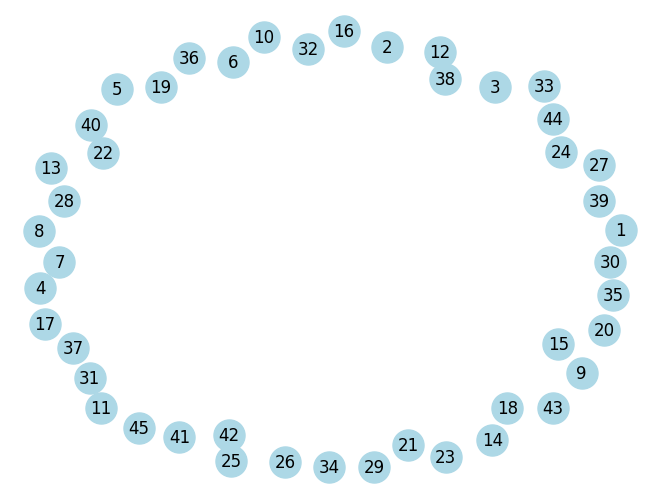

In [12]:
import xml.etree.ElementTree as ET
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
path = '../data/fisher-1994-set-f/F-n045-k4.xml'
def transfer_xml_to_nxgraph(path):
    # Load the VRP-REP XML file
    tree = ET.parse(path)
    root = tree.getroot()
    G = nx.DiGraph()

    #for elem in root.iter():
    #    print(f'Element: {elem.tag}, Attributes: {elem.attrib}')
    #    if elem.text is not None:
    #        print(f'  Text: {elem.text.strip()}')

    # Print specific elements of interest
    for customer in root.findall('./network/nodes/node'):
        id = customer.get('id')
        cx = customer.find('cx').text  # Get the text content of <cx>
        cy = customer.find('cy').text 
        pos = (cx,cy)
        type = customer.get('type')
        if(id !='1'):
            demand_item = root.find(f"./requests/request[@node='{id}']")
            demand_sin = demand_item.find('quantity').text
        else:
            demand_sin = 0
        G.add_node(id,pos=pos,demand = demand_sin)
        print(f'Customer ID: {id},Customer type: {type} Demand: {demand_sin}')
    nx.draw(G, with_labels=True, node_color='lightblue', node_size=500)

    # Display the plot
    plt.show()
    return G
transfer_xml_to_nxgraph(path)

We want to generate the Hij term for Qij in QUBO.

In [13]:
num_customers = 5
position = 5
A = 7 # penalty coefficient A >max{d}
B=1 
array = np.random.rand(num_customers,num_customers)
D = array


In [14]:
import itertools
distances = D
# Generate all permutations of the cities, excluding the first city to fix the starting point
perms = list(itertools.permutations(range(1, len(distances))))

# Initialize minimum distance to a large number
min_distance = float('inf')
best_route = None

# Check each permutation
for perm in perms:
    # Include the starting city at the beginning and the end to complete the cycle
    route = (0,) + perm + (0,)
    # Calculate the total distance of the current permutation
    current_distance = sum(distances[route[i]][route[i+1]] for i in range(len(route) - 1))
    
    # Update minimum distance and best route
    if current_distance < min_distance:
        min_distance = current_distance
        best_route = route

min_distance, best_route


(0.6646403505527121, (0, 2, 4, 1, 3, 0))

In [15]:
def calculate_Q(num_customers,position,A,B,weight):
    
    Q = np.zeros((num_customers*position,num_customers*position))
    for k in range(num_customers):
        for i in range(position):
            for j in range(position):
                if i == j:
                    Q[i+k*position, j+k*position] = -A 
                else:
                    Q[i+k*position, j+k*position] += 2*A
                    
    for k in range(position):
        for i in range(num_customers):
            for j in range(num_customers):
                if i == j:
                    Q[k+i*position, k+j*position] += -A 
                else:
                    Q[k+i*position, k+j*position] += 2*A
                    
    for k in range(num_customers):
        for i in range(num_customers):
                for j in range(position):
                    if i != k:
                        Q[k*position+j, i*position+(j+1)%position] += B*weight[k,i]
                        Q[k*position+j, i*position+(j-1)%position] += B*weight[i,k]

    return Q
Qubo = calculate_Q(num_customers = num_customers,position = position,A = A,B=B,weight =D)


In [16]:
np.set_printoptions(precision=2, suppress=True)
def print_matrix(matrix):
    for row in matrix:
        print(" ".join(map(str, row)))
print_matrix(Qubo)

-14.0 14.0 14.0 14.0 14.0 14.0 0.1942974852130065 0.0 0.0 0.5467772453446605 14.0 0.08190006001834516 0.0 0.0 0.8456720544791447 14.0 0.26938469527986364 0.0 0.0 0.06759889360357696 14.0 0.6501305180131334 0.0 0.0 0.2794595536486242
14.0 -14.0 14.0 14.0 14.0 0.5467772453446605 14.0 0.1942974852130065 0.0 0.0 0.8456720544791447 14.0 0.08190006001834516 0.0 0.0 0.06759889360357696 14.0 0.26938469527986364 0.0 0.0 0.2794595536486242 14.0 0.6501305180131334 0.0 0.0
14.0 14.0 -14.0 14.0 14.0 0.0 0.5467772453446605 14.0 0.1942974852130065 0.0 0.0 0.8456720544791447 14.0 0.08190006001834516 0.0 0.0 0.06759889360357696 14.0 0.26938469527986364 0.0 0.0 0.2794595536486242 14.0 0.6501305180131334 0.0
14.0 14.0 14.0 -14.0 14.0 0.0 0.0 0.5467772453446605 14.0 0.1942974852130065 0.0 0.0 0.8456720544791447 14.0 0.08190006001834516 0.0 0.0 0.06759889360357696 14.0 0.26938469527986364 0.0 0.0 0.2794595536486242 14.0 0.6501305180131334
14.0 14.0 14.0 14.0 -14.0 0.1942974852130065 0.0 0.0 0.5467772453446

In [17]:
def get_maxcutGraph_weight(Qubo,n):
    maxcutG = (Qubo + Qubo.T)/2
    extended_array = np.zeros((n+1,n+1))
    extended_array[1:n+1,1:n+1] = maxcutG
    for i in range(n):
        for j in range(n):
            if(i!=j):
                extended_array[0,i] += 0.5*(Qubo[i,j]+Qubo[j,i])
            else:
                extended_array[0,i] += (Qubo[i,i])
    for i in range(n-1):
        extended_array[i+1,0] = extended_array[0,i]
    return extended_array
maxcut = get_maxcutGraph_weight(Qubo,num_customers*position) 
print(maxcut)          

[[100.94 100.94 100.94 100.94 100.94 101.22 101.22 101.22 101.22 101.22
  100.91 100.91 100.91 100.91 100.91 100.59 100.59 100.59 100.59 100.59
  100.55 100.55 100.55 100.55 100.55   0.  ]
 [100.94 -14.    14.    14.    14.    14.    14.     0.19   0.     0.
    0.55  14.     0.08   0.     0.     0.85  14.     0.27   0.     0.
    0.07  14.     0.65   0.     0.     0.28]
 [100.94  14.   -14.    14.    14.    14.     0.55  14.     0.19   0.
    0.     0.85  14.     0.08   0.     0.     0.07  14.     0.27   0.
    0.     0.28  14.     0.65   0.     0.  ]
 [100.94  14.    14.   -14.    14.    14.     0.     0.55  14.     0.19
    0.     0.     0.85  14.     0.08   0.     0.     0.07  14.     0.27
    0.     0.     0.28  14.     0.65   0.  ]
 [100.94  14.    14.    14.   -14.    14.     0.     0.     0.55  14.
    0.19   0.     0.     0.85  14.     0.08   0.     0.     0.07  14.
    0.27   0.     0.     0.28  14.     0.65]
 [100.94  14.    14.    14.    14.   -14.     0.19   0.     0.     

In [18]:
n = num_customers*position +1  # the node for QAOA to solve

In [19]:
import cudaq
from cudaq import spin

from typing import List
cudaq.set_target('nvidia')
maxcut_list = maxcut.flatten().tolist()
print(maxcut_list)
# Here we build up a kernel for QAOA with `p` layers, with each layer
# containing the alternating set of unitaries corresponding to the problem
# and the mixer Hamiltonians. The algorithm leverages the VQE algorithm
# to compute the Max-Cut of a rectangular graph illustrated below.

#       v0  0---------------------0 v1
#           |                     |
#           |                     |
#           |                     |
#           |                     |
#       v3  0---------------------0 v2
# The Max-Cut for this problem is 0101 or 1010.
hamiltonian = 0
# The problem Hamiltonian
for i in range(n):
    for j in range(n):
        hamiltonian += maxcut_list[i*n+j]*spin.z(i) * spin.z(j)
        
#hamiltonian = 0.5 * spin.z(0) * spin.z(1) + 0.5 * spin.z(1) * spin.z(2) \
#       + 0.5 * spin.z(0) * spin.z(3) + 0.5 * spin.z(2) * spin.z(3)

# Problem parameters.
qubit_count: int = n
layer_count: int = 1
parameter_count: int = 2 * layer_count


@cudaq.kernel
def kernel_qaoa(qubit_count: int, layer_count: int, thetas: List[float]):
    """QAOA ansatz for Max-Cut"""
    qvector = cudaq.qvector(qubit_count)
    # Create superposition
    h(qvector)

    # Loop over the layers
    for layer in range(layer_count):
        # Loop over the qubits
        # Problem unitary
        for qubit1 in range(qubit_count):
            for qubit2 in range(qubit_count):
                if(qubit1>qubit2):
                    x.ctrl(qvector[qubit1], qvector[(qubit2 ) % qubit_count])
                    rz(-2.0 * maxcut_list[qubit1*qubit_count+qubit2]*thetas[layer], qvector[(qubit2) % qubit_count])
                    x.ctrl(qvector[qubit1], qvector[(qubit2) % qubit_count])

        # Mixer unitary
        for qubit in range(qubit_count):
            rx(2.0 * thetas[layer + layer_count], qvector[qubit])


# Specify the optimizer and its initial parameters. Make it repeatable.
cudaq.set_random_seed(13)
optimizer = cudaq.optimizers.COBYLA()
np.random.seed(13)
optimizer.initial_parameters = np.random.uniform(-np.pi / 8.0, np.pi / 8.0,
                                                 parameter_count)
print("Initial parameters = ", optimizer.initial_parameters)

# Define the objective, return `<state(params) | H | state(params)>`
def objective(parameters):
    return cudaq.observe(kernel_qaoa, hamiltonian, qubit_count, layer_count,
                         parameters).expectation()

# Optimize!
optimal_expectation, optimal_parameters = optimizer.optimize(
    dimensions=parameter_count, function=objective)

# Print the optimized value and its parameters
print("Optimal value = ", optimal_expectation)
print("Optimal parameters = ", optimal_parameters)

# Sample the circuit using the optimized parameters
counts = cudaq.sample(kernel_qaoa, qubit_count, layer_count, optimal_parameters)
print(counts)

[100.93522050560034, 100.93522050560034, 100.93522050560034, 100.93522050560034, 100.93522050560034, 101.22304069694351, 101.22304069694351, 101.22304069694351, 101.22304069694351, 101.22304069694351, 100.90645401641855, 100.90645401641855, 100.90645401641855, 100.90645401641855, 100.90645401641855, 100.59142682677628, 100.5914268267763, 100.5914268267763, 100.5914268267763, 100.59142682677628, 100.54869756608053, 100.54869756608055, 100.54869756608055, 100.54869756608055, 100.54869756608053, 0.0, 100.93522050560034, -14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 0.1942974852130065, 0.0, 0.0, 0.5467772453446605, 14.0, 0.08190006001834516, 0.0, 0.0, 0.8456720544791447, 14.0, 0.26938469527986364, 0.0, 0.0, 0.06759889360357696, 14.0, 0.6501305180131334, 0.0, 0.0, 0.2794595536486242, 100.93522050560034, 14.0, -14.0, 14.0, 14.0, 14.0, 0.5467772453446605, 14.0, 0.1942974852130065, 0.0, 0.0, 0.8456720544791447, 14.0, 0.08190006001834516, 0.0, 0.0, 0.06759889360357696, 14.0, 0.26938469527986364, 0.0, 0.